# How HDBSCAN Works

Blatantly ripped off and adapted from https://github.com/scikit-learn-contrib/hdbscan .

HDBSCAN is a clustering algorithm developed by [Campello, Moulavi, and Sander](http://link.springer.com/chapter/10.1007%2F978-3-642-37456-2_14). It extends DBSCAN by converting it into a hierarchical clustering algorithm, and then using a technique to extract a flat clustering based in the stability of clusters. The goal of this notebook is to give you an overview of how the algorithm works. This algorithm is conceptuually similar to [Robust Single Linkage](http://cseweb.ucsd.edu/~dasgupta/papers/tree.pdf) with [flat cluster extraction](http://link.springer.com/article/10.1007%2Fs10618-013-0311-4) on top of it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

## Toy data

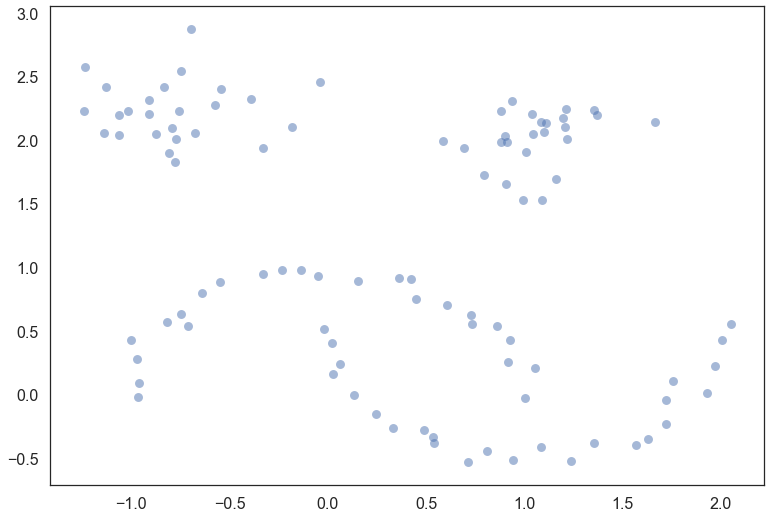

In [2]:
moons, _ = data.make_moons(n_samples=50, noise=0.05)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
test_data = np.vstack([moons, blobs])
plt.scatter(test_data.T[0], test_data.T[1], color='b', **plot_kwds)

## Cluster toy data

In [3]:
import hdbscan

Clustering is easy using python:

In [4]:
# Cluster with a minimum cluster size of 5, and we're going to have the code save 
# an intermediate step "gen_min_span_tree" for discussion later.

# First, prepare a clusterer object with your parameters. You can set no parameters and sensible defaults will be used.
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)

# Now, fit the data
clusterer.fit(test_data)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, core_dist_n_jobs=4, gen_min_span_tree=True,
    leaf_size=40, memory=Memory(cachedir=None), metric='euclidean',
    min_cluster_size=5, min_samples=None, p=None)

All Done! Wasn't that easy?

But what actually happened? We can break it out into a series of steps

1. Transform the space according to the density/sparsity.
2. Build the minimum spanning tree of the distance weighted graph.
3. Construct a cluster hierarchy of connected components.
4. Condense the cluster hierarchy based on minimum cluster size.
5. Extract the stable clusters from the condensed tree.

## Transform the space

Conceptually, we want to find areas of higher density separated by sparse regions of noise.

To do this, we need an estimate of density. HDBSCAN defines "dense" for the data. We don't need to know what "dense" means *a priori*. So, even for very high dimensional data where the Euclidean distance between points might be huge, HDBSCAN will still be just fine. It is designed to work for arbitrarily dense or sparse data sets.

So, we need a very inexpensive estimate of density, We define **core distance** for a parameter *k* and a point *x*, denoted $\mathrm{core}_k(x)$. We alsop define **mutual reachability distance**:

<center>$d_{\mathrm{mreach-}k}(a,b) = \max \{\mathrm{core}_k(a), \mathrm{core}_k(b), d(a,b) \}$</center>

where $d(a,b)$ is the original metric distance between *a* and *b*. Under this metric dense points (with low core distance) remain the same distance from each other but sparser points are pushed away to be at least their core distance away from any other point. Obviously, this is sensitive to your choice of *k*; larger *k* values interpret more points as sparse regions of noise. Using a *k* value of five, for a given point we can draw a circle for the core distance as the circle that touches the sixth nearest neighbor (counting the point itself), like so:

<img src="distance1.svg" alt="Diagram demonstrating mutual reachability distance" width=640 height=480>

Pick another point and we can do the same thing.

<img src="distance2.svg" alt="Diagram demonstrating mutual reachability distance" width=640 height=480>

And a third time

<img src="distance3.svg" alt="Diagram demonstrating mutual reachability distance" width=640 height=480>

Now if we want to know the mutual reachabiility distance between the blue and green points we can start by drawing in and arrow giving the distance between green and blue:

<img src="distance4.svg" alt="Diagram demonstrating mutual reachability distance" width=640 height=480>

This passes through the blue circle, but not the green circle -- the core distance for green is larger than the distance between blue and green. Thus we need to mark the mutual reachability distance between blue and green as larger -- equal to the radius of the green circle (easiest to picture if we base one end at the green point).

<img src="distance4a.svg" alt="Diagram demonstrating mutual reachability distance" width=640 height=480>

On the other hand the mutual reachablity distance from red to green is simply distance from red to green since that distance is greater than either core distance (i.e. the distance arrow passes through both circles).

<img src="distance5.svg" alt="Diagram demonstrating mutual reachability distance" width=640 height=480>

In general there is [underlying theory](http://arxiv.org/pdf/1506.06422v2.pdf) to demonstrate that mutual reachability distance as a transform works well in allowing single linkage clustering to more closely approximate the hierarchy of level sets of whatever true density distribution our points were sampled from.

## Build the minimum spanning tree

Now that we have a new mutual reachability metric on the data we want start finding dense regions. Density is relative, and different regions may have different densities. Consider the data as a weighted graph with the data points as vertices and an edge between any two points with weight equal to the mutual reachability distance of those points.

Now consider a threshold value, starting high, and steadily being lowered. Drop any edges with weight above that threshold. As we drop edges we will start to disconnect the graph into connected components. Eventually we will have a hierarchy of connected components (from completely connected to completely disconnected) at varying threshold levels.

Annoyingly, there are $n^2$, making this computationally expensive, so we'll frame this problem in a non-iterative fashion. We want minimal set of edges such that dropping any edge from the set causes a disconnection of components with the constraint that there is no lower weight edge that could connect the components. In graph theory, this very thing is called *the minimum spanning tree of the graph*. It differs from the typical definition in that this is the minimum spanning tree using mutual reachability distance. 

We can build the minimum spanning tree very efficiently via [Prim's algorithm](https://en.wikipedia.org/wiki/Prim%27s_algorithm) -- we build the tree one edge at a time, always adding the lowest weight edge that connects the current tree to a vertex not yet in the tree. In our minimum spanning tree is for mutual reachibility distance with *k*=5.

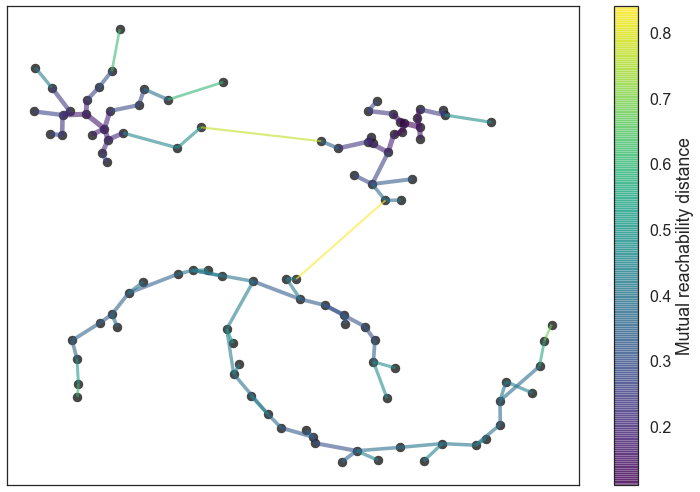

In [5]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis', 
                                      edge_alpha=0.6, 
                                      node_size=80, 
                                      edge_linewidth=2)

## Build the cluster hierarchy

Given the minimal spanning tree, the next step is to convert that into the hierarchy of connected components. This is most easily done in the reverse order: sort the edges of the tree by distance (in increasing order) and then iterate through, creating a new merged cluster for each edge. The only difficult part here is to identify the two clusters each edge will join together, but this is easy enough via a [union-find](https://en.wikipedia.org/wiki/Disjoint-set_data_structure) data structure. We can view the result as a dendrogram as we see below:

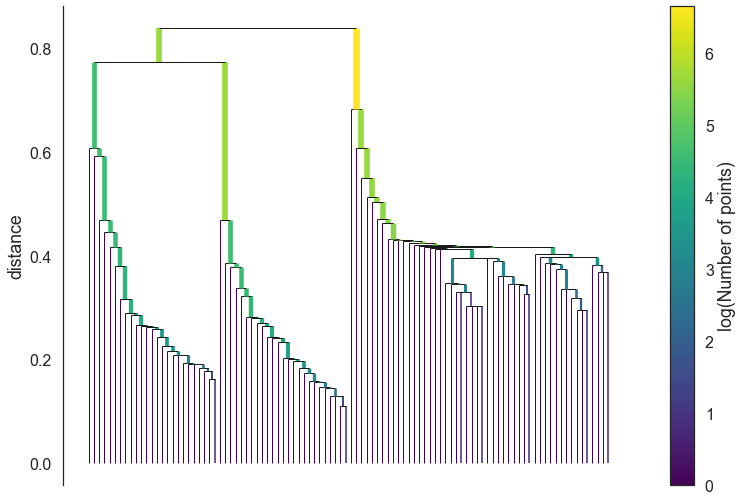

In [6]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

This brings us to the point where robust single linkage stops. We want more though; a cluster hierarchy is good, but we really want a set of flat clusters. To achieve this, HDBSCAN will cut the tree at different places to select our clusters. This is where the next steps of HDBSCAN begin and create the difference from robust single linkage.

** Potentially useful definitions **

*Flat clustering* creates a flat set of clusters without any explicit structure that would relate clusters to each other. 

*Hierarchical clustering* creates a hierarchy of clusters.

HDBSCAN is brining together these two seemingly orthogonal ideas.

## Condense the cluster tree

The first step in cluster extraction is condensing down the large and complicated cluster hierarchy into a smaller tree with a little more data attached to each node. As you can see in the hierarchy above it is often the case that a cluster split is one or two points splitting off from a cluster; and that is the key point -- rather than seeing it as a cluster splitting into two new clusters we want to view it as a single persistent cluster that is 'losing points'. To make this concrete we need a notion of **minimum cluster size** which we take as a parameter to HDBSCAN. Once we have a value for minimum cluster size we can now walk through the hierarchy and at each split ask if one of the new clusters created by the split has fewer points than the minimum cluster size. If it is the case that we have fewer points than the minimum cluster size we declare it to be 'points falling out of a cluster' and have the larger cluster retain the cluster identity of the parent, marking down which points 'fell out of the cluster' and at what distance value that happened. If on the other hand the split is into two clusters each at least as large as the minimum cluster size then we consider that a true cluster split and let that split persist in the tree. After walking through the whole hierarchy and doing this we end up with a much smaller tree with a small number of nodes, each of which has data about how the size of the cluster at that node descreases over varying distance. We can visualize this as a dendrogram similar to the one above -- again we can have the width of the line represent the number of points in the cluster. This time, however, that width varies over the length of the line as points fall our of the cluster. For our data using a minimum cluster size of 5 the result looks like this:

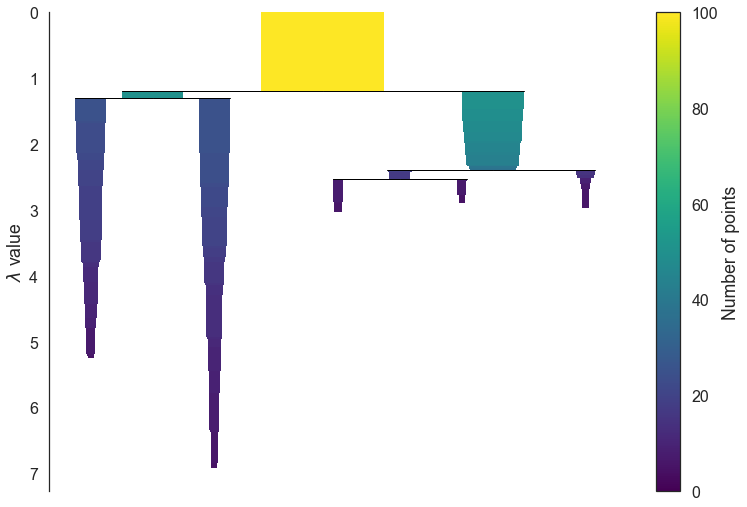

In [7]:
clusterer.condensed_tree_.plot()

We still need to pick out clusters to use as a flat clustering. 

## Extract the clusters

Intuitively we want the choose clusters that persist and have a longer lifetime; short lived clusters are probably artifacts of the hierarchical process we started with. Looking at the previous plot we could say that we want to choose those clusters that have the greatest area of ink in the plot. To make a flat clustering we will need to add requirement that, if you select a cluster, then you cannot select any cluster that is a descendant of it. 

First we need a different measure than distance to consider the persistence of clusters; instead we will use $\lambda = \frac{1}{\mathrm{distance}}$. For a given cluster we can then define values $\lambda_{\mathrm{birth}}$ and $\lambda_{\mathrm{death}}$ to be the lambda value when the cluster split off and became its own cluster, and the lambda value (if any) when the cluster split into smaller clusters respectively. In turn, for a given cluster, for each point *p* in that cluster we can define the value $\lambda_p$ as the lambda value at which that point 'fell out of the cluster' which is a value somewhere between $\lambda_{\mathrm{birth}}$ and $\lambda_{\mathrm{death}}$ since the point either falls out of the cluster at some point in the cluster's lifetime, or leaves the cluster when the cluster splits into two smaller clusters. Now, for each cluster compute the **stability** to as

$\sum_{p \in \mathrm{cluster}} (\lambda_p - \lambda_{\mathrm{birth}})$.

Declare all leaf nodes (ends of the dendrogram) to be selected clusters. Now work up through the tree. If the sum of the stabilities of the child clusters is greater than the stability of the cluster then we set the cluster stability to be the sum of the child stabilities. If, on the other hand, the cluster's stability is greater than the sum of its children then we declare the cluster to be a selected cluster, and unselect all its descendants. Once we reach the root node we call the current set of selected clusters our flat clsutering and return that.

This formal algorithm is simply performing the 'select the clusters in the plot with the largest total ink area' subject to descendant constraints explained earlier. We can select the clusters in the condensed tree dendrogram via this algorithm, and you get what you expect:

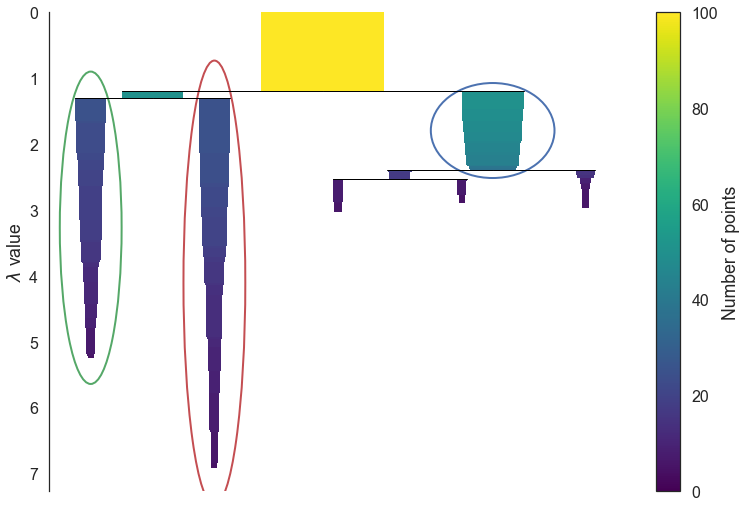

In [8]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

HDBSCAN returns the clustering following the sklearn API. That is, any point not in a selected cluster is simply a noise point (and assigned the label -1). We can do a little more though: for each cluster we have the $\lambda_p$ for each point *p* in that cluster; If we simply normalize those values (so they range from zero to one) then we have a measure of the strength of cluster membership for each point in the cluster. The hdbscan library returns this as a `probabilities_` attribute of the clusterer object. Thus, with labels and membership strengths in hand we can make the standard plot, choosing a color for points based on cluster label, and desaturating that color according the strength of membership (and make unclustered points pure gray).

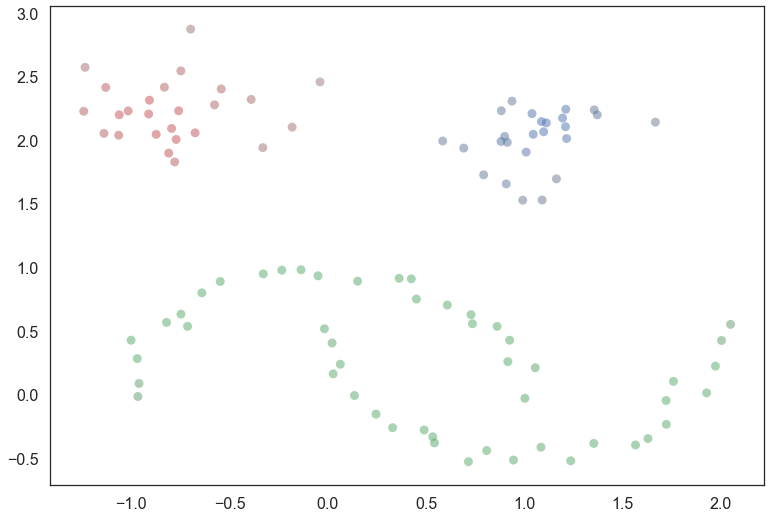

In [9]:
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat) 
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in 
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(test_data.T[0], test_data.T[1], c=cluster_colors, **plot_kwds)

Voila!